In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
from functions import basic
from functions import interaction
from functions import evolution
%matplotlib inline

In [2]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython){
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [3]:
# reading input file
filename = "fcc100a256.txt"
lattice = basic.read_file(filename)

In [4]:
# computing ditances, finding neighbours

# no PBC test
start = time.process_time()
for i in range(100):
    mask,distances = basic.find_neighbours(*lattice)
print(f'no PBC - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

start = time.process_time()
for i in range(100):
    mask,distances = basic.find_neighbours(*lattice, PBC=True)
print(f'PBC - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

no PBC - 100 iterations; computing time: 0.57 seconds
PBC - 100 iterations; computing time: 0.59 seconds


In [6]:
# calculating potential energy
mask,distances = basic.find_neighbours(*lattice)

# approximate LJ
start = time.process_time()
for i in range(100):
    LJA = interaction.lennard_jones_approx(distances)
print(f'approximate LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

# true LJ
start = time.process_time()
for i in range(100):
    LJ = interaction.lennard_jones(distances)
print(f'true LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

print('')
print(f'approximate LJ: {LJA:.2f}')
print(f'true LJ: {LJ:.2f}')

approximate LJ - 100 iterations; computing time: 0.77 seconds
true LJ - 100 iterations; computing time: 0.85 seconds

approximate LJ: -453.45
true LJ: -532.48


In [20]:
# calculating forces

# approximate LJ
start = time.process_time()
for i in range(100):
    FxA,FyA,FzA = interaction.calc_force_approx(*lattice,distances,PBC=True)
print(f'approximate LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

# approximate LJ
start = time.process_time()
for i in range(100):
    Fx,Fy,Fz = interaction.calc_force(*lattice,distances,PBC=True)
print(f'true LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

print('')
print(f'approximate LJ, force on 0-th atom: {FxA[1]:.2f},{FyA[1]:.2f},{FzA[1]:.2f}')
print(f'true LJ, force on 0-th atom: {Fx[1]:.2f},{Fy[1]:.2f},{Fz[1]:.2f}')

approximate LJ - 100 iterations; computing time: 2.75 seconds
true LJ - 100 iterations; computing time: 3.13 seconds

approximate LJ, force on 0-th atom: 0.00,0.00,0.00
true LJ, force on 0-th atom: 0.00,0.00,0.37


### Test zone - used for quick tests and monkey patch

In [21]:
n_atoms,sx,sy,sz,x,y,z = lattice

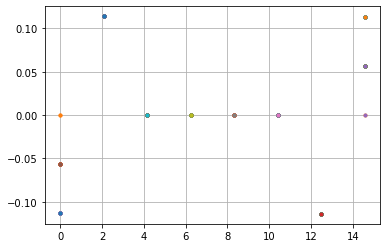

In [25]:
for i in range(255):
    plt.plot(x[i],FxA[i],'.')
plt.grid()

In [ ]:
# constant values 
rc = 4.625
rp = 4.375
sigma = 2.644
epsilon = 0.345
kb = 1/11603
Temp = 100
m_ag = 108*1.66e-27/16

In [ ]:
n_atoms,sx,sy,sz,x,y,z = lattice

coord_x =  np.column_stack((x,np.zeros(n_atoms),np.zeros(n_atoms)))
coord_y =  np.column_stack((np.zeros(n_atoms),y,np.zeros(n_atoms)))
coord_z =  np.column_stack((np.zeros(n_atoms),np.zeros(n_atoms),z))
x_distances = np.sum(coord_x[:,None,:] - coord_x, axis=-1)
y_distances = np.sum(coord_y[:,None,:] - coord_y, axis=-1)        
z_distances = np.sum(coord_z[:,None,:] - coord_z, axis=-1)

distances[np.where(distances==0)] = np.infty

In [ ]:
Fx = 24*epsilon*( 2*sigma**12*(distances)**(-14) - sigma**6*(distances)**(-8) )*(x_distances)

In [ ]:
mask_x_plus = x_distances>(0.5*sx)
mask_y_plus = y_distances>(0.5*sy)
mask_x_minus = x_distances<(-0.5*sx)
mask_y_minus = y_distances<(-0.5*sy)
x_distances = x_distances - sx*mask_x_plus + sx*mask_x_minus
y_distances = y_distances - sy*mask_y_plus + sy*mask_y_minus

Fx_pbc = 24*epsilon*( 2*sigma**12*(distances)**(-14) - sigma**6*(distances)**(-8) )*(x_distances)

In [ ]:
print(x[1])
print()

for i in range(255):   
    print(x[i])
    print(Fx[1][i])
    print(Fx_pbc[1][i])
    print()

In [ ]:
Fx_tot = 0
Fx_tot_pbc = 0

for i in range(255):
    Fx_tot = Fx_tot + Fx[1][i]
    Fx_tot_pbc = Fx_tot_pbc + Fx_pbc[1][i]
    
Fx_tot, Fx_tot_pbc

In [ ]:
mask,distances = basic.find_neighbours(*lattice)

n_atoms,sx,sy,sz,x,y,z = lattice

coord_x =  np.column_stack((x,np.zeros(n_atoms),np.zeros(n_atoms)))
coord_y =  np.column_stack((np.zeros(n_atoms),y,np.zeros(n_atoms)))
coord_z =  np.column_stack((np.zeros(n_atoms),np.zeros(n_atoms),z))
x_distances = np.sum(coord_x[:,None,:] - coord_x, axis=-1)
y_distances = np.sum(coord_y[:,None,:] - coord_y, axis=-1)        
z_distances = np.sum(coord_z[:,None,:] - coord_z, axis=-1)

distances[np.where(distances==0)] = np.infty



mask_x_plus = x_distances>(0.5*sx)
mask_y_plus = y_distances>(0.5*sy)
mask_x_minus = x_distances<(-0.5*sx)
mask_y_minus = y_distances<(-0.5*sy)
x_distances = x_distances - sx*mask_x_plus + sx*mask_x_minus
y_distances = y_distances - sy*mask_y_plus + sy*mask_y_minus
x_distances[np.where(np.abs(x_distances)==0.5*sx)] = 0

Fx_pbc = 24*epsilon*( 2*sigma**12*(distances)**(-14) - sigma**6*(distances)**(-8) )*(x_distances)
Fx_pbc = np.nansum(Fx_pbc,axis=1)

Fy_pbc = 24*epsilon*( 2*sigma**12*(distances)**(-14) - sigma**6*(distances)**(-8) )*(y_distances)
Fy_pbc = np.nansum(Fy_pbc,axis=1)

Fz_pbc = 24*epsilon*( 2*sigma**12*(distances)**(-14) - sigma**6*(distances)**(-8) )*(z_distances)
Fz_pbc = np.nansum(Fz_pbc,axis=1)

In [ ]:
for i in range(255):
    plt.plot(x[i],Fx_pbc[i],'.')
plt.grid()

In [ ]:
for i in range(255):
    plt.plot(y[i],Fy_pbc[i],'.')
plt.grid()

In [ ]:
for i in range(255):
    plt.plot(z[i],Fz_pbc[i],'.')
plt.grid()

In [ ]:
mask,distances = basic.find_neighbours(*lattice)

n_atoms,sx,sy,sz,x,y,z = lattice

coord_x =  np.column_stack((x,np.zeros(n_atoms),np.zeros(n_atoms)))
coord_y =  np.column_stack((np.zeros(n_atoms),y,np.zeros(n_atoms)))
coord_z =  np.column_stack((np.zeros(n_atoms),np.zeros(n_atoms),z))
x_distances = np.sum(coord_x[:,None,:] - coord_x, axis=-1)
y_distances = np.sum(coord_y[:,None,:] - coord_y, axis=-1)        
z_distances = np.sum(coord_z[:,None,:] - coord_z, axis=-1)

distances[np.where(distances==0)] = np.infty

In [ ]:
x_distances[0]

In [ ]:
np.sum(x_distances[0])

In [ ]:
mask_x_plus = x_distances>(0.5*sx)
mask_y_plus = y_distances>(0.5*sy)
mask_x_minus = x_distances<(-0.5*sx)
mask_y_minus = y_distances<(-0.5*sy)
x_distances = x_distances - sx*mask_x_plus + sx*mask_x_minus
y_distances = y_distances - sy*mask_y_plus + sy*mask_y_minus
x_distances[np.where(np.abs(x_distances)==0.5*sx)] = 0

In [ ]:
x_distances[0]

In [ ]:
np.sum(x_distances[0])